In [ ]:
!pip install Pillow
!pip install keras-unet
!pip install transformers==4.30.2 torch==2.0.1
!pip install scikit-learn

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from glob import glob
from skimage.io import imread
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator
from google.colab.patches import cv2_imshow
from keras_unet.models import custom_unet
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import to_categorical
from keras.optimizers import Adam
from PIL import Image


-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from keras.models import load_model

# Load the model
base_model = load_model('/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5')

In [ ]:
# paths for training and testing sets
training_set = '/content/drive/MyDrive/Brain Tumor data/Training'
test_set = '/content/drive/MyDrive/Brain Tumor data/Testing'

In [ ]:
# preprocess training set and save to drive
def preprocess_images(training_set, target_set, target_size=(512, 512)):
  if not os.path.exists(target_set):
        os.makedirs(target_set)

  preprocessed_data = []
  tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]
  for tumor_type in tumor_types:
    type_path = os.path.join(training_set, tumor_type)
    target_type_path = os.path.join(target_set, tumor_type)

    if not os.path.exists(target_type_path):
            os.makedirs(target_type_path)

    if os.path.isdir(type_path):
      print(f"Processing directory: {type_path}")

      for image_name in os.listdir(type_path):
        image_path = os.path.join(type_path, image_name)
        target_image_path = os.path.join(target_type_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          pil_image = Image.fromarray(image_rgb)
          resized_image = pil_image.resize((512, 512))
          resized_image.save(target_image_path)
          print(f"Saved image: {target_image_path}")
        else:
          print(f"Failed to read image: {image_path}")

training_set = '/content/drive/MyDrive/Brain Tumor data/Training'
resized_set = '/content/drive/MyDrive/Brain Tumor data/Resized Training'
preprocessed_data = preprocess_images(training_set, resized_set, (512, 512))


In [ ]:
# preprocess test set and save to drive
def preprocess_images(test_set, target_set, target_size=(512, 512)):
  if not os.path.exists(target_set):
        os.makedirs(target_set)

  preprocessed_data = []
  tumor_types = ["glioma", "meningioma", "notumor", "pituitary"]
  for tumor_type in tumor_types:
    type_path = os.path.join(test_set, tumor_type)
    target_type_path = os.path.join(target_set, tumor_type)

    if not os.path.exists(target_type_path):
            os.makedirs(target_type_path)

    if os.path.isdir(type_path):
      print(f"Processing directory: {type_path}")

      for image_name in os.listdir(type_path):
        image_path = os.path.join(type_path, image_name)
        target_image_path = os.path.join(target_type_path, image_name)
        image = cv2.imread(image_path)
        if image is not None:
          image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
          pil_image = Image.fromarray(image_rgb)
          resized_image = pil_image.resize((512, 512))
          resized_image.save(target_image_path)
          print(f"Saved image: {target_image_path}")
        else:
          print(f"Failed to read image: {image_path}")

test_set = '/content/drive/MyDrive/Brain Tumor data/Testing'
resized_set = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'
preprocessed_data = preprocess_images(test_set, resized_set, (512, 512))

In [ ]:
# transfer learning ~ MobileNetVt
from keras.applications import MobileNetV2
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import Adam

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(512, 512, 3))

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

#Freeze base layers
for layer in base_model.layers:
    layer.trainable = False


model.compile(optimizer=Adam(learning_rate=0.000066),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
from keras.optimizers import Adam

# Load the trained model
model_path = '/content/drive/MyDrive/Brain Tumor data/model84.h5'
model = load_model(model_path)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.000066),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# load preprocessed images
resized_training = '/content/drive/MyDrive/Brain Tumor data/Resized Training'
resized_testing = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'


# data augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=110,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.3,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    channel_shift_range=0.2,
    vertical_flip=True,
    brightness_range=[0.5, 1.5]
)

# Validation data generator (no augmentation)
valid_datagen = ImageDataGenerator(rescale=1./255)

# generator for training data
train_generator = datagen.flow_from_directory(
    resized_training,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

# generator for validation data
valid_generator = train_datagen.flow_from_directory(
    resized_training,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=False,
    subset='validation'
)

# generator for testing data
test_generator = datagen.flow_from_directory(
    resized_testing,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

from sklearn.utils.class_weight import compute_class_weight

# Get class weights
class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes=np.unique(train_generator.classes),
    y=train_generator.classes )

class_weights = dict(enumerate(class_weights))

meningioma_class_weight = 1
class_weights[meningioma_class_weight] *=2.7
class_weights[0]*=1.5


print(class_weights)

print("Training Class:", train_generator.n)
print("Validation Class:", valid_generator.n)
print("Testing Class:", test_generator.n)


Found 4595 images belonging to 4 classes.
Found 1147 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
{0: 1.5940101757631824, 1: 2.893306902985075, 2: 0.9002742946708464, 3: 0.9852058319039451}
Training Class: 4595
Validation Class: 1147
Testing Class: 1311


In [ ]:
## MODEL TRAINING

from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Callbacks for saving progress
#checkpoint_callback = ModelCheckpoint(
    #'/content/drive/MyDrive/Brain Tumor data/mobilenetv2.h5',
    #save_best_only=True,
    #monitor='val_loss',
    #mode='min'
#)
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = valid_generator.n // valid_generator.batch_size
test_steps = test_generator.n // test_generator.batch_size

print("Starting training...")
history = model.fit(
    train_generator,
    steps_per_epoch=50,
    epochs=1,
    validation_data=valid_generator,
    validation_steps=50,
    class_weight=class_weights,
    #callbacks=[checkpoint_callback]
)

print("Training complete.")


Starting training...
50/50 [==============================] - ETA: 0s - loss: 0.5749 - accuracy: 0.8764

50/50 [==============================] - 233s 5s/step - loss: 0.5749 - accuracy: 0.8764 - val_loss: 1.3090 - val_accuracy: 0.5475
Training complete.


In [ ]:
model.save('/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# MODEL TESTING

from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np


model_path = '/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5'
model = load_model(model_path)

datagen = ImageDataGenerator(rescale=1./255)
resized_testing = '/content/drive/MyDrive/Brain Tumor data/Resized Testing'


test_generator = datagen.flow_from_directory(
    resized_testing,
    target_size=(512, 512),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

# Evaluate the loaded model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

# make predictions
predictions = model.predict(test_generator)
predicted_classes= np.argmax(predictions, axis=1)
y_true = test_generator.classes

#get true classes:
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
print("Classification Report:")
report = classification_report(y_true, predicted_classes, target_names=class_labels)
print(report)


Found 1311 images belonging to 4 classes.
21/21 [==============================] - 55s 3s/step - loss: 0.4184 - accuracy: 0.8413
Test accuracy: 0.8413425087928772
Test loss: 0.41836264729499817
21/21 [==============================] - 55s 3s/step
Classification Report:
              precision    recall  f1-score   support

      glioma       0.93      0.72      0.81       300
  meningioma       0.67      0.72      0.70       306
     notumor       0.90      0.95      0.93       405
   pituitary       0.87      0.93      0.90       300

    accuracy                           0.84      1311
   macro avg       0.84      0.83      0.83      1311
weighted avg       0.85      0.84      0.84      1311



In [ ]:
# Save the model
model.save('/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5')

Tumor Type: Meningioma


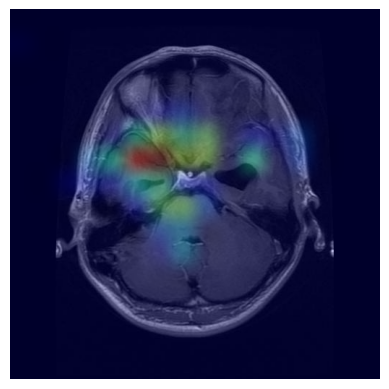

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


A Meningioma brain tumor has been identified. 
 Meningiomas are typically benign and slow-growing tumors that originate from the meninges, 
 the protective layers surrounding the brain and spinal cord. They may cause symptoms by pressing 
 on the brain or spinal cord, leading to headaches, seizures, or neurological deficits. Treatment 
 often involves surgical removal, and the prognosis is generally favorable. 
 




In [ ]:
## GRAD-CAM INTEGRATION

import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing import image
from keras.models import load_model, Model
from keras.layers import Conv2D
import tensorflow as tf
import matplotlib

#load model
model_path = '/content/drive/MyDrive/Brain Tumor data/NeuroModel.h5'
base_model = load_model(model_path)


conv_layers = [layer for layer in base_model.layers if isinstance(layer, Conv2D)]

# pick a layer to visualize
chosen_layer = conv_layers[-1].name # last conv layer

def get_img_array(img_path, size):
  img = image.load_img(img_path, target_size=size)
  array = image.img_to_array(img)
  array = np.expand_dims(array, axis=0)
  array = array / 255.0
  return array


def make_gradcam_map(img_array, layer_name, model, pred_index=None):
  grad_model = Model(inputs=[model.inputs], outputs=[model.get_layer(chosen_layer).output, model.output])
  with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    if pred_index is None:
      pred_index = tf.argmax(predictions[0]) # finds class index w/ highest predicted score
    class_channel = predictions[:, pred_index]

  grads = tape.gradient(class_channel, conv_outputs)
  pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

  conv_outputs = conv_outputs[0]
  heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
  heatmap = tf.squeeze(heatmap)
  heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
  return heatmap.numpy(), np.argmax(predictions[0].numpy())

def display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
  img = image.load_img(img_path)
  img = image.img_to_array(img)
  heatmap = np.uint8(255 * heatmap)

  jet = matplotlib.colormaps['jet']
  jet_colors = jet(np.arange(256))[:, :3]
  jet_heatmap = jet_colors[heatmap]

  jet_heatmap = image.array_to_img(jet_heatmap)
  jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
  jet_heatmap = image.img_to_array(jet_heatmap)

  superimposed_img = jet_heatmap * alpha + img
  superimposed_img = image.array_to_img(superimposed_img)
  superimposed_img.save(cam_path)

  plt.imshow(superimposed_img)
  plt.axis('off')
  plt.show()


img_path = 'path/to/testing/image'

img_array = get_img_array(img_path, (512, 512))

heatmap, pred_index = make_gradcam_map(img_array, chosen_layer, base_model)
class_indices = train_generator.class_indices
tumor_types = list(class_indices.keys())
print("Tumor Type:", tumor_types[pred_index].capitalize())
display_gradcam(img_path, heatmap)

import transformers
from transformers import GPT2Model, GPT2Config, GPT2Tokenizer, GPT2LMHeadModel

configuration = GPT2Config()
model = GPT2Model(configuration)
configuration = model.config
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")


if tokenizer.pad_token_id is None:
    tokenizer.pad_token_id = tokenizer.eos_token_id

# get predicted tumor
tumor_identified = tumor_types[pred_index].capitalize()
base_prompt = {
    "Meningioma": ("A Meningioma brain tumor has been identified. \n "
                   "Meningiomas are typically benign and slow-growing tumors that originate from the meninges, \n "
                   "the protective layers surrounding the brain and spinal cord. They may cause symptoms by pressing \n "
                   "on the brain or spinal cord, leading to headaches, seizures, or neurological deficits. Treatment \n "
                   "often involves surgical removal, and the prognosis is generally favorable. \n "),
    "Glioma": ("A Glioma brain tumor has been identified. Gliomas are a type of tumor that arises from glial cells in the brain. \n"
               "They can be benign or malignant and are categorized into different grades based on their aggressiveness. \n "
               "Symptoms can include headaches, seizures, and neurological impairments. Treatment typically involves surgery, \n "
               "radiation therapy, and chemotherapy."),
    "Pituitary": ("A Pituitary tumor has been identified. Pituitary tumors are abnormal growths that develop in the pituitary gland, \n "
                  "which is located at the base of the brain. These tumors can affect hormone production, leading to various endocrine disorders. \n "
                  "Symptoms may include vision problems, headaches, and hormonal imbalances. Treatment options include medication, surgery, and radiation therapy. \n"),
    "No Tumor": ("No brain tumor has been identified. This could mean the observed abnormalities are not due to a tumor but might be due to other factors such as \n"
                 "inflammation, infection, or benign conditions. Further medical evaluation and imaging are recommended to determine the exact cause.\n")
}
input_text = base_prompt.get(tumor_identified, "No information available for this type of tumor.")

input_ids = tokenizer(input_text, return_tensors="pt")['input_ids']
inputs = tokenizer(input_text, return_tensors="pt")

# Generate the text with attention mask
generated_text = model.generate(
    inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    max_length=90,
    pad_token_id=tokenizer.eos_token_id
)

output_text = tokenizer.decode(generated_text[0], skip_special_tokens=True)

print(output_text)